# Exploring the Relationship Between Player Age and Playtime for Targeted Newsletter Campaigns
Names: Danial Zahid,  Peter Wang

Date: December 6th, 2025

## Introduction

Understanding player engagement on game servers is crucial for successful communication strategies, such as newsletter campaigns. Players choose to subscribe to a newsletter for updates, research information, and community links. Discovering which player profiles subscribe will aid researchers in more effectively reaching and retaining committed participants.

This project explores whether player characteristics, specifically **player age** and **time spent playing**, can be used to predict if a player will subscribe to the game newsletter. By analyzing this relationship, we can identify which age groups are most engaged with the game and could be the most responsive to future newsletter campaigns.

The data was collected from a Minecraft research server managed by the UBC PLAI group (https://plaicraft.ai), which collects information about players' 
demographics and statistics. This analysis will focus on the **players.csv dataset**, which contains demographic information such as players' age, subscription status, and the amount of time played. Once the data has been cleaned, wrangled, and prepared, we will apply the k-nearest neighbours (KNN) classification model to examine whether age and playtime predict newsletter subscription.

**Question of Interest:** Is there a relationship between the age of players and the time they spend playing that could inform which group of players to target for newsletter subscription campaigns?

Response Variable: 'subscribe'

Explanatory Variable: 'Age', 'played_hours'

## Methods and Results

First, we loaded the **players.csv** dataset and selected the variables needed for the classification model. There were some players who had missing values for 'age' and 'played_hours', so these were removed. Additionally, we have decided to convert the 'subscribe' indicator to a categorical variable and filtered out players with zero playtime, since they provide no meaningful information.

In [2]:
# Load the libraries
library(tidyverse)
library(ggplot2)
library(repr)
library(scales)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [3]:
# Load the dataset
players <- read_csv("players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [4]:
# Find the number of rows and columns
cat("Number of observations:", nrow(players), "\n")
cat("Number of variables:", ncol(players), "\n")

Number of observations: 196 
Number of variables: 7 


In [5]:
# Show the variable names of the dataset
colnames(players)

[1] "experience"   "subscribe"    "hashedEmail"  "played_hours" "name"        
[6] "gender"       "Age"

From the information generated above from loading the data, we can see that "players" contains data on 196 different users. 
We have information regarding each player's:
- Minecraft experience
- Newsletter subscription status
- Email ID
- Time spent playing on the server (in hours)
- Name
- Gender
- Age

Our investigation will focus on the "subscribe", "Age", and "played_hours" variables. 

Upon inspecting the data and identifying the variables of value to us, we must address a few potential issues we see within the dataset.
1. The data appears to be skewed towards players who put in their information but may not have at all intended to produce data for the research.
2. There may not be enough data from certain age ranges to generalize findings in this analysis to greater populations.

We will address the first issue by removing all observations with 0 hours played, since they are a unique group that does not provide insight into our investigation. The decision to participate in the study without contributing any time is a pattern that transcends any variable, including age. This isn't a perfect solution, but it will remove pointless observations and help us avoid a regression analysis that is influenced by them.

Our utilization of linear regression will address the second issue. Even though the method reveals stronger correlation in some datasets than others, we can clarify this variance through visualization. How much or little the results of this analysis should be valued is ultimately at the discretion of the UBC Computer Science researchers.

In [6]:
#filter out the players who played 0 hours
players_filtered <- players |>
filter(played_hours > 0)

We will be using this filtered dataframe from now on, since it excludes observations that are not useful to us. Now we will collect some statistics that will contribute to our understanding of the sample we've been given. We will find the mean and standard deviation of the age of all participants and the time each of them spent on the server.

In [7]:
players_statistics <- players_filtered |>
summarize(mean_age = mean(Age, na.rm = TRUE), sd_age = sd(Age, na.rm = TRUE), mean_hours = mean(played_hours), sd_hours = sd(played_hours))
players_statistics

mean_age,sd_age,mean_hours,sd_hours
<dbl>,<dbl>,<dbl>,<dbl>
21.30275,7.652771,10.32252,37.1334


We'll now take a first look at the categorical variable we'll be looking at – the subscription status of each player.

In [8]:
subscribe_count <- players_filtered |>
count(subscribe)
subscribe_count

subscribe,n
<lgl>,<int>
FALSE,25
TRUE,86


Out of the 111 players who actually spent time on the server, 86 were subscribed, while 25 were not. 

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


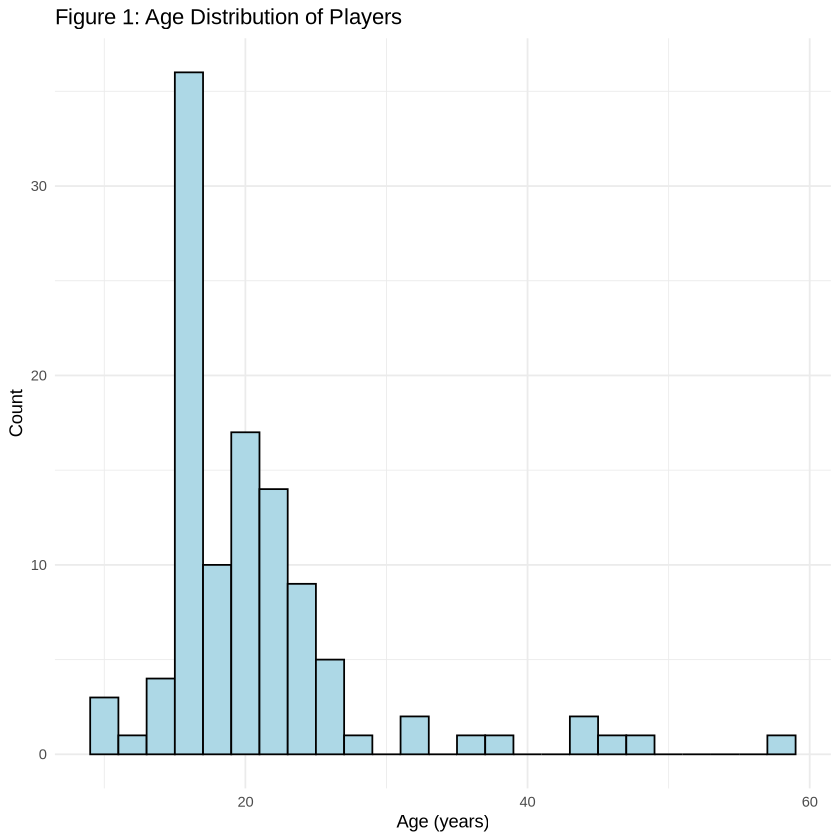

In [9]:
figure1 <- ggplot(players_filtered, aes(x = Age)) +
  geom_histogram(binwidth = 2, fill = "lightblue", color = "black") +
  labs(title = "Figure 1: Age Distribution of Players",
       x = "Age (years)", y = "Count") +
  theme_minimal()
figure1

The histogram shows that the largest majority of players who have subscribed to a game newsletter are between 10 and 30 years old, with a high concentration of players who are around ages 15-20. There are very few players who are older than 40. This indicates that most current subscriptions are from younger players and shows that they are likely the most appropriate group for newsletter-targeting campaigns. Furthermore, the number of players who have subscribed to the newsletter is more than double the number who have not subscribed.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


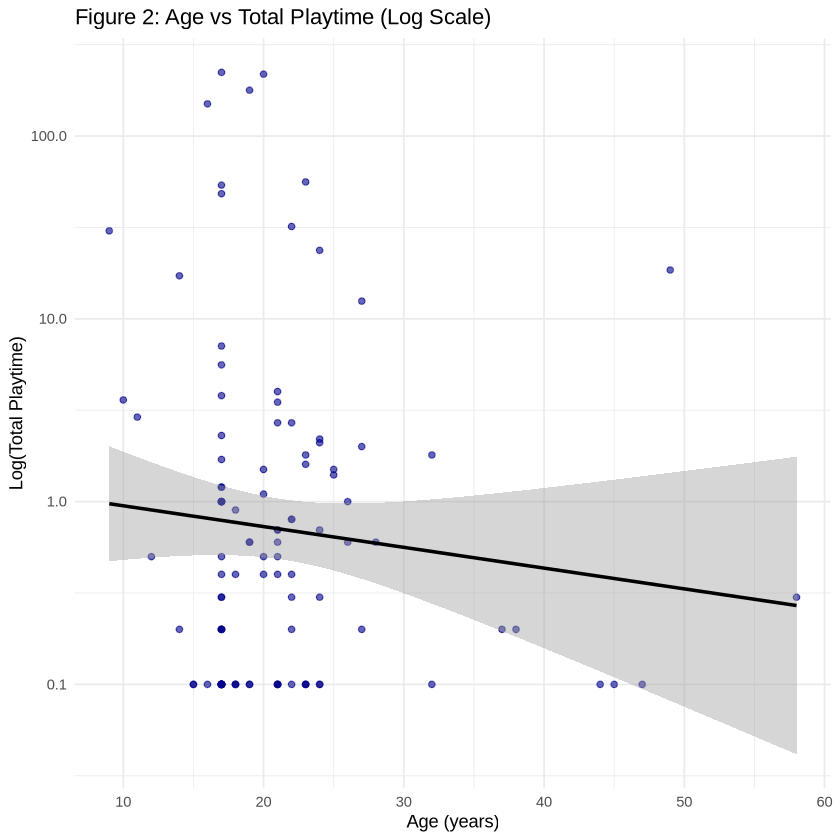

In [14]:
figure2 <- ggplot(players_filtered, aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.6, color = "darkblue") +
  scale_y_log10() +
  geom_smooth(method = "lm", color = "black", se = TRUE) +
  labs(title = "Figure 2: Age vs Total Playtime (Log Scale)",
    x = "Age (years)", y = "Log(Total Playtime)") +
  theme_minimal()
figure2

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


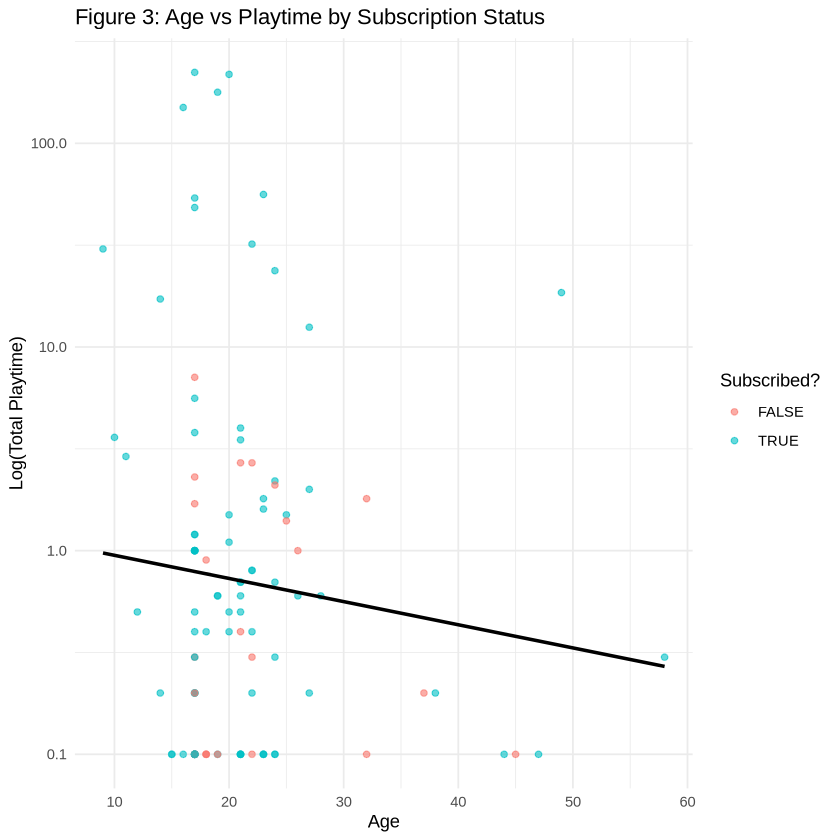

In [13]:
figure3 <- ggplot(players_filtered, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.6) +
  scale_y_log10() +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(title = "Figure 3: Age vs Playtime by Subscription Status",
       x = "Age", y = "Log(Total Playtime)", color = "Subscribed?") +
  theme_minimal()
figure3

The scatterplots show that most players have relatively low playtime hours, but there are a few players who have higher hours, with outliers spending 150 or more hours. The trend shows a weak or slightly negative linear relationship, meaning that as 'Age' increases, the 'played_hours' tends to decrease. This suggests that younger players are more active in the game compared to older players.

## Discussion

-

## GitHub Repository Link

-